In [1]:
##Basic

import numpy as np
import pandas as pd

## Visualization

import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pprint import pprint

## ML

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE

## Algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import shap
from sklearn.datasets import make_classification

/Users/nikhiljagirdar/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# read the churn data

df = pd.read_csv('/Users/nikhiljagirdar/Personal_DS_projects/Customer_churn/Churn_Modelling.csv')

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [3]:
df.shape

(10002, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


In [5]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [29]:
variable_interested = [
    'CreditScore',
    'Geography',
    'Gender',
    'Age',
    'Tenure',
    'Balance',
    'NumOfProducts',
    'HasCrCard',
    'IsActiveMember',
    'EstimatedSalary',
    'Exited',
]

data_selected = df.loc[:, variable_interested]

In [30]:
data_selected['IsActiveMember'] = data_selected['IsActiveMember'].astype(object)
data_selected['HasCrCard'] = data_selected['HasCrCard'].astype(object)

In [35]:
data_selected['Gender'].value_counts().index[-1]

'Female'

## 1.1 EDA

In [39]:
def missing_value(data) :
    df = pd.DataFrame(columns = ['variable', 'Unique values', 'Nan %', 'zeros %', 'mean', 'median', 'std', 'least frequent', 'Most frequent'])
    
    for col in data.columns:
        
        unique_values = data[col].unique()
        
        try:
            unique_values = np.sort(unique_values)
        except:
            pass
        
        nans =round(pd.isna(data[col]).sum() / data.shape[0] *100,1)
        zeros= round((data[col] == 0).sum() / data.shape[0] *100,1)
        
        # calculate mean, median, and standard deviation
        try:
            mean_value = data[col].mean()
            median_value = data[col].median()
            std_value =data[col].std()
        except:
            # handle non-numeric column
            mean_value =  None
            median_value =  None
            std_value = None
        
        # calculate least and most frequent object value for non-numeric
        
        try:
            least_occ = None
            most_occ = None         
        except: 
            least_occ = df[col].value_counts().index[-1]
            most_occ = df[col].value_counts().index[0]
            
        
        # Add a new row to the Dataframe
        new_row = pd.DataFrame([[col, len(unique_values), nans, zeros, mean_value, median_value, std_value, least_occ, most_occ]],
                               columns = ['variable', 'Unique values', 'Nan %', 'zeros %', 'mean', 'median', 'std','least frequent', 'Most frequent'])
        df = pd.concat([df, new_row], ignore_index=True)
    return df.sort_values('Nan %', ascending=False)

# Call the function

missing_value(data_selected)

/var/folders/qs/gh02k6953x123bhbyh11240c0000gn/T/ipykernel_4690/998894727.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


,variable,Unique values,Nan %,zeros %,mean,median,std,least frequent,Most frequent
0,CreditScore,460,0.0,0.0,650.555089,652.00,96.661615,None,None
1,Geography,4,0.0,0.0,NaN,NaN,NaN,None,None
2,Gender,2,0.0,0.0,NaN,NaN,NaN,None,None
3,Age,74,0.0,0.0,38.922311,37.00,10.487200,None,None
4,Tenure,11,0.0,4.1,5.012498,5.00,2.891973,None,None
5,Balance,6382,0.0,36.2,76491.112875,97198.54,62393.474144,None,None
6,NumOfProducts,4,0.0,0.0,1.530194,1.00,0.581639,None,None
7,HasCrCard,3,0.0,29.4,0.705529,1.00,0.455827,None,None
8,IsActiveMember,3,0.0,48.5,0.514949,1.00,0.499801,None,None
9,EstimatedSalary,9999,0.0,0.0,100083.331145,100185.24,57508.117802,None,None


In [67]:
# Let's examine the credit score of the churn group
data_selected["CreditScore"].describe([0.05,0.25,0.50,0.75,0.90,0.95,0.99])

count    10002.000000
mean       650.555089
std         96.661615
min        350.000000
5%         489.000000
25%        584.000000
50%        652.000000
75%        718.000000
90%        778.000000
95%        812.000000
99%        850.000000
max        850.000000
Name: CreditScore, dtype: float64

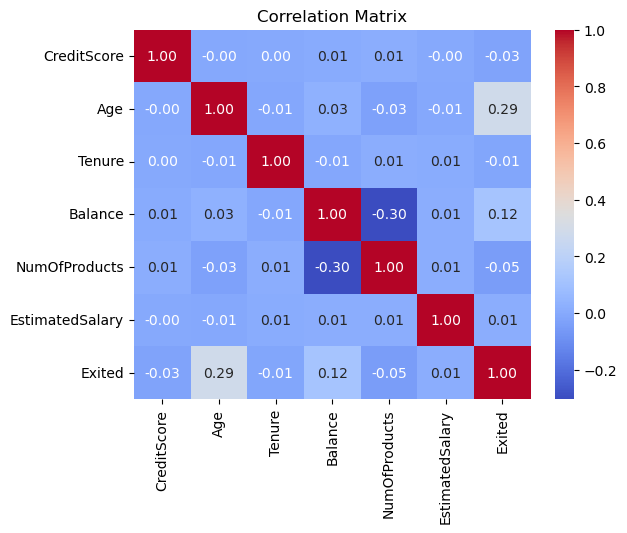

In [38]:
# calculate correlation matrix for numerical variables

corr_matrix = data_selected.select_dtypes(include= ['int64','float64']).corr(method='pearson')

# Visualize the correlation matrix using a heatmap

sns.heatmap(corr_matrix, annot=True, cmap = 'coolwarm', fmt= ".2f")
plt.title('Correlation Matrix')
plt.show()

In [71]:
# Exited correlation matrix
k = 10 #number of variables for heatmap
cols = df.corr().nlargest(k, 'Exited')['Exited'].index
#cm = df[cols].corr()
#plt.figure(figsize=(10,6))
#sns.heatmap(cm, annot=True, cmap = 'viridis')

ValueError: could not convert string to float: 'Hargrave'

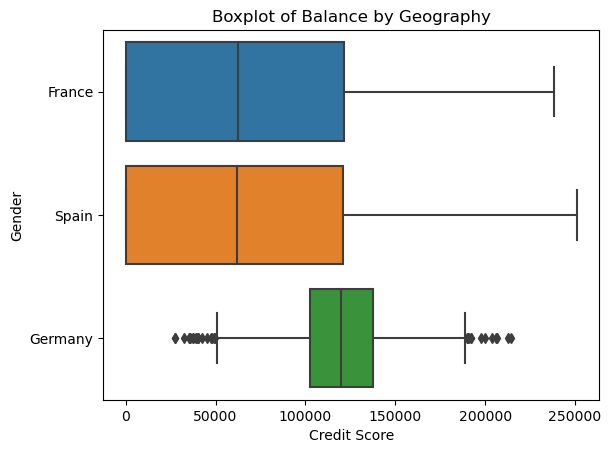

In [45]:
# Boxplot creditscore by Gender

sns.boxplot(x= 'Balance', y='Geography', data = data_selected)
plt.title('Boxplot of Balance by Geography')
plt.xlabel('Credit Score')
plt.ylabel('Gender')
plt.show()

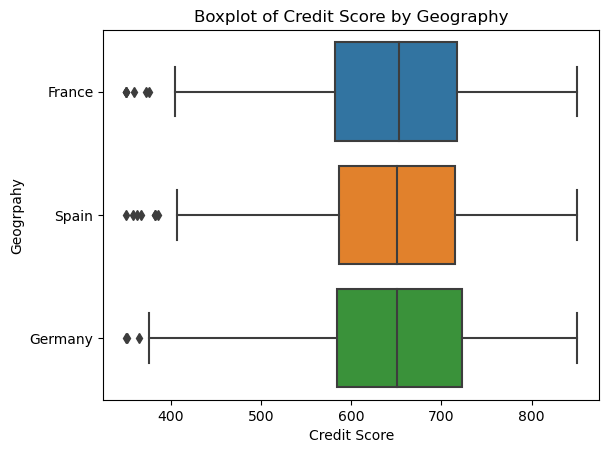

In [42]:
# Boxplot creditscore by Geography

sns.boxplot(x= 'CreditScore', y='Geography', data = data_selected)
plt.title('Boxplot of Credit Score by Geography')
plt.xlabel('Credit Score')
plt.ylabel('Geogrpahy')
plt.show()

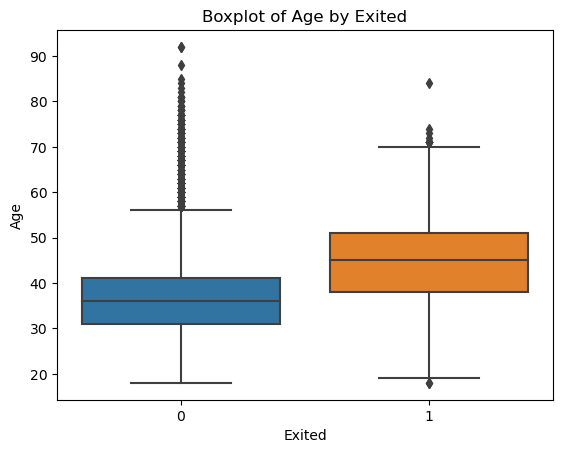

In [65]:
# Boxplot creditscore by Geography

sns.boxplot(x= 'Exited', y='Age', data = data_selected)
plt.title('Boxplot of Age by Exited')
plt.xlabel('Exited')
plt.ylabel('Age')
plt.show()

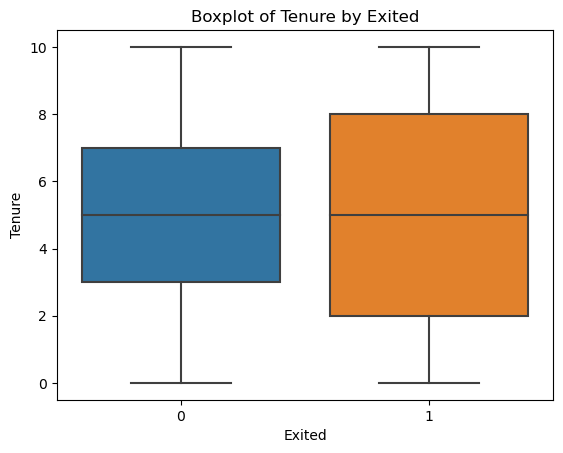

In [62]:
# Boxplot creditscore by Geography

sns.boxplot(x= 'Exited', y='Tenure', data = data_selected)
plt.title('Boxplot of Tenure by Exited')
plt.xlabel('Exited')
plt.ylabel('Tenure')
plt.show()

/Users/nikhiljagirdar/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


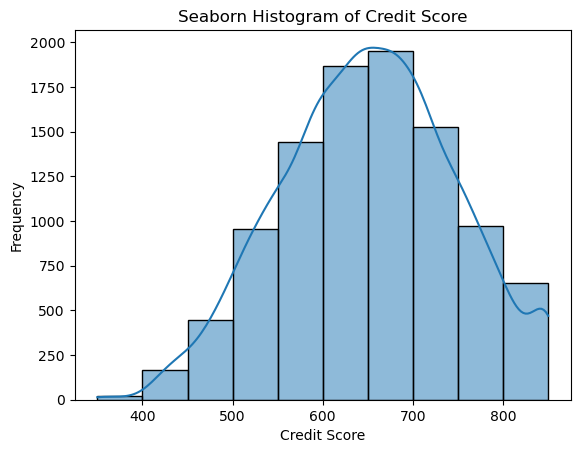

In [48]:
# Create the histogram

sns.histplot(data=df, x='CreditScore', bins=10, kde=True)
plt.title('Seaborn Histogram of Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.show()

/Users/nikhiljagirdar/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


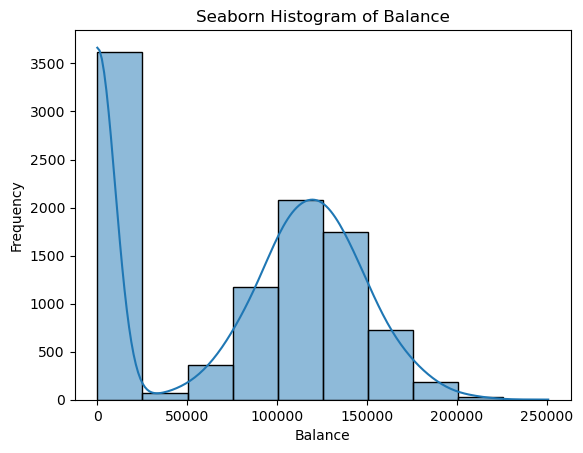

In [49]:
# Create the histogram

sns.histplot(data=df, x='Balance', bins=10, kde=True)
plt.title('Seaborn Histogram of Balance')
plt.xlabel('Balance')
plt.ylabel('Frequency')
plt.show()

/Users/nikhiljagirdar/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


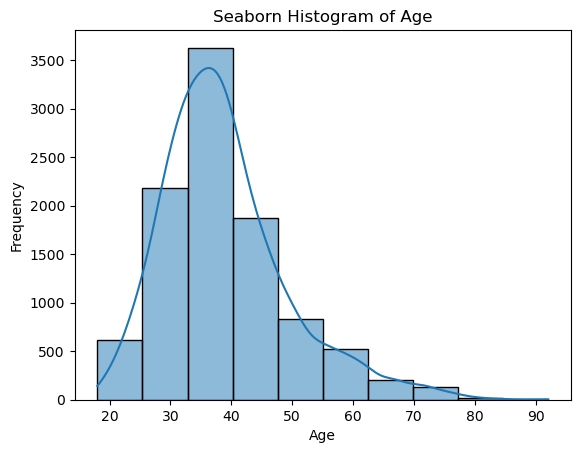

In [53]:
# Create the histogram

sns.histplot(data=df, x='Age', bins=10, kde=True)
plt.title('Seaborn Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

/Users/nikhiljagirdar/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


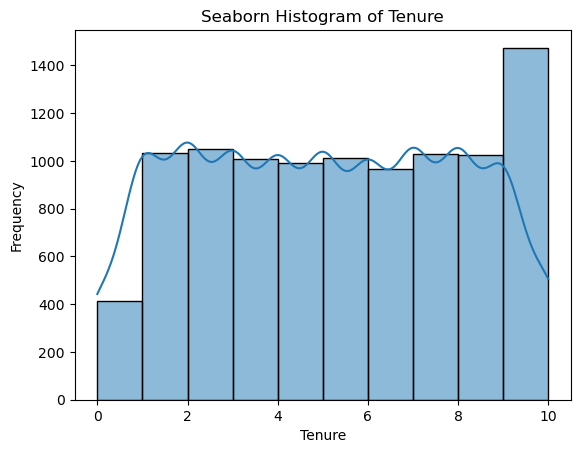

In [54]:
# Create the histogram

sns.histplot(data=df, x='Tenure', bins=10, kde=True)
plt.title('Seaborn Histogram of Tenure')
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.show()